# Evaluation by Date

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
from ipywidgets import interact

import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
# from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss

from beeid.utils import sensitivity_map

from beeid2.models import simple_cnnv2, ContrastiveLearning
from beeid2.data_utils import load_tf_pair_dataset, load_tf_dataset
from beeid2.viz import show_sensitivity_maps
from beeid2.evaluation import cmc_evaluation, plot_cmc
from beeid2.evaluation import get_interactive_plot_query_gallery
from beeid2.data_utils import filename2image

IMAGE_FOLDER = "/mnt/storage/work/jchan/normalized_uncensored_dataset/images/"
DATASET_CSV = "/mnt/storage/work/jchan/body_dataset2/dataset3.csv"

### Prepare dataset

Select the dates for Training, Validation and Testing datasets.

In [2]:
def filter_dataframe(df):
    filtered_df = df[(df.closest_bee > 300)]
    filtered_df = filtered_df[filtered_df.abdomen_size >= 230]
    filtered_df = filtered_df[filtered_df.abdomen_angle >= 200]
    filtered_df = filtered_df[filtered_df.abdomen_angle <= 330]
    filtered_df = filtered_df[filtered_df.V_mean >= 0.30]
    return filtered_df.copy()

df = pd.read_csv(DATASET_CSV)

df = filter_dataframe(df)
df= df[df.tag_id != -1.0]
df["datetime2"] = pd.to_datetime(df["datetime"])
df["days"] = df["datetime2"].dt.strftime("%Y-%m-%d")
df["global_track_id"] = df["video_name"] + "_" + df["track_id"].apply(str)
df["filename"] = IMAGE_FOLDER + df.filename
df["day_int"] = df["datetime2"].dt.strftime("%d").astype(int)

train_df = df[df.days <= '2019-07-23']
valid_df = df[(df.days > '2019-07-23') & (df.days < '2019-07-25')]
test_df = df[(df.days >= '2019-08-01') & (df.days <= '2019-08-04')]
test_df = test_df.sort_values("datetime2")
len(train_df), len(valid_df), len(test_df)

(3777, 1909, 3276)

In [3]:
# test_df = pd.read_csv("data/test.csv")
# test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

# Creating a tracking evaluation

In [4]:
test_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'track_id', 'frame', 'angle', 'x', 'y',
       'parts_num', 'tag_id', 'virtual', 'pollen_score', 'tagx', 'tagy',
       'taghamming', 'tagdm', 'datetime', 'track_tag_id', 'headx', 'heady',
       'waistx', 'waisty', 'neckx', 'necky', 'tailx', 'taily', 'closest_bee',
       'num_bees_frame', 'filename', 'video_name', 'abdomen_size',
       'normalized_abdomen_size', 'R_mean', 'G_mean', 'B_mean',
       'abdomen_angle', 'H_mean', 'S_mean', 'V_mean', 'datetime2', 'days',
       'global_track_id', 'day_int'],
      dtype='object')

In [5]:
test_df[test_df.global_track_id == "38_02_R_190804180000_15118"]

,Unnamed: 0,Unnamed: 0.1,track_id,frame,angle,x,y,parts_num,tag_id,virtual,...,G_mean,B_mean,abdomen_angle,H_mean,S_mean,V_mean,datetime2,days,global_track_id,day_int
21662,21662,199374,15118,37498,148.29857,608,1024,4,2715.0,False,...,112,114,241.699244,0.327862,0.222446,0.483336,2019-08-04 18:31:14.900,2019-08-04,38_02_R_190804180000_15118,4


In [6]:
# for global_track_id in test_df.global_track_id.unique():
#     d= test_df[test_df.global_track_id == global_track_id]
#     print(len(d))

# Creating a re-id evalutaion

In [7]:
periods = list()
for tid in test_df.track_tag_id.unique():
    sample_track_df = test_df[test_df.track_tag_id == tid]
    gtracks = sample_track_df.groupby("global_track_id").apply(lambda x: x.iloc[0]).sort_values("datetime2")
    dates = gtracks.datetime2.values
    gtids = gtracks.global_track_id.values
    days_int =  gtracks.day_int.values
    for i, (gid1, d1, day1) in enumerate(zip(gtids, dates, days_int)):
        for gid2, d2, day2 in zip(gtids[i+1:], dates[i+1:], days_int[i+1:]):
            diff = d2 - d1
            day_diff = day2 - day1
            periods.append((tid, gid1, gid2, diff.astype('timedelta64[m]'), day_diff))

In [8]:
timegap = pd.DataFrame(periods, columns=["track_tag_id", "gid1", "gid2",  "timegap", "dategap"])

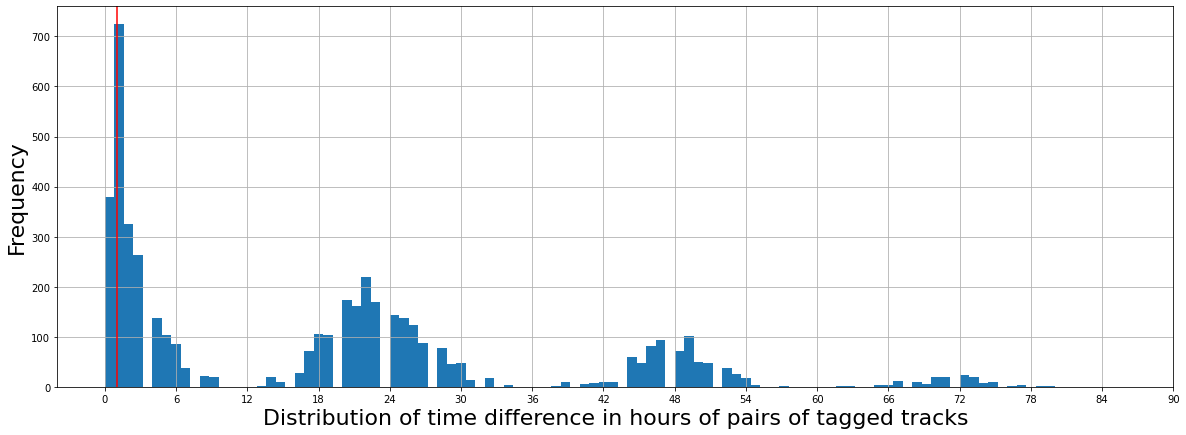

In [9]:
plt.figure(figsize=(20, 7))
minutes = timegap.timegap.astype('timedelta64[m]')
hours = timegap[minutes > 15].timegap.astype('timedelta64[h]')
# hours = minutes/60.0
xticks = range(0, 24*4, 6)
hours.hist(bins=100)
plt.axvline(x=1, c="red")
plt.xticks(xticks);
plt.xlabel("Distribution of time difference in hours of pairs of tagged tracks", fontsize=22)
plt.ylabel("Frequency", fontsize=22)
plt.savefig("long_term_timegap_distribution.png")

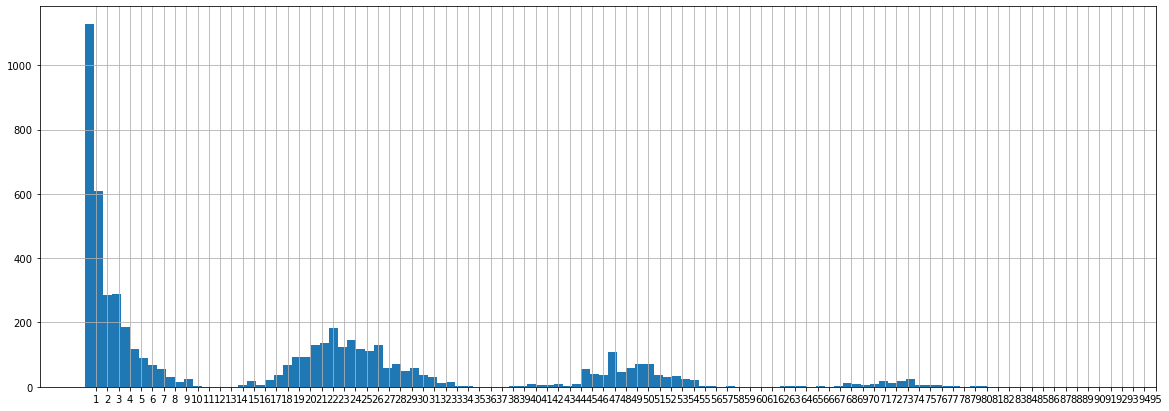

In [24]:
plt.figure(figsize=(20, 7))
minutes = timegap.timegap.astype('timedelta64[h]')
# hours = minutes/60.0
xticks = range(1, 24*4)
hours.hist(bins=100)
plt.xticks(xticks);

In [7]:
def get_timegap_query_gallery(row, query_df, dfGroupedbyTagId, limit=None):
    query = query_df[query_df.global_track_id == row.gid1].sample().iloc[0]
    key = query_df[query_df.global_track_id == row.gid2].sample().iloc[0]
    
    negatives = dfGroupedbyTagId.apply(lambda x: x.iloc[np.random.randint(len(x))])
    different_tag = (negatives.index != row.track_tag_id)
    negatives = negatives[different_tag]
    
    if limit is not None:
        negatives = negatives.sample(limit)
    query_gallery = np.concatenate(([query.filename, key.filename], negatives.filename.values))
    return query_gallery

In [8]:
def timegap_dataset(df, timegap_df, iterations=100, gallery_size=None):
    """
    model: keras model
    df: a dataframe with the image to evaluate
    
    """
    cdf = df.copy()
    dfGroupedbyTagId = cdf.groupby("track_tag_id")
    
    iteration_ids = list()
    query_ids = list()
    image_ids = list()
    galleries = list()
    for it in tqdm(range(iterations)):
        queries_and_galleries = list()
        for j, (i, query_data) in enumerate(timegap_df.iterrows()):
            query_gallery =  get_timegap_query_gallery(query_data, cdf, dfGroupedbyTagId, limit=gallery_size)
            queries_and_galleries.append(query_gallery)
            
            iteration_ids.append(np.ones(len(query_gallery)) * it)
            query_ids.append(np.ones(len(query_gallery)) * j)
            image_ids.append(np.arange(0, len(query_gallery)))
            galleries.append(query_gallery)
    
    iteration_ids = np.array(iteration_ids).ravel().astype(int)
    query_ids = np.array(query_ids).ravel().astype(int)
    image_ids = np.array(image_ids).ravel()
    galleries = np.array(galleries).ravel()
    
    df = pd.DataFrame({"iteration_id":iteration_ids, "gallery_id":query_ids, "image_id": image_ids,  "filename":galleries})
    return df
        
        

100%|██████████| 100/100 [51:32<00:00, 30.92s/it]


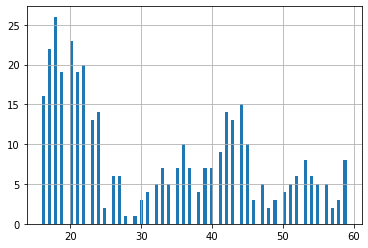

In [11]:
greater_than_15min= timegap.timegap.astype('timedelta64[m]') > 15
same_hour = timegap.timegap.astype('timedelta64[h]') < 1

d = timegap[greater_than_15min & same_hour]
d.timegap.astype('timedelta64[m]').hist(bins=100)

df = timegap_dataset(test_df, d, iterations=100)
df.to_csv("data/test_same_hour2.csv")

100%|██████████| 100/100 [33:24<00:00, 20.04s/it]


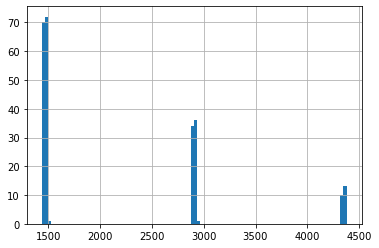

In [12]:
next_day= timegap.timegap.astype('timedelta64[h]') >= 24
same_hour = (timegap.timegap.astype('timedelta64[h]') % 24) == 0

d = timegap[next_day & same_hour]
d.timegap.astype('timedelta64[m]').hist(bins=100)

df = timegap_dataset(test_df, d, iterations=100)
df.to_csv("data/test_different_day_same_hour2.csv")

In [ ]:
next_days= timegap.timegap.astype('timedelta64[h]') >= 24

d = timegap[next_days]
d.timegap.astype('timedelta64[m]').hist(bins=100)

df = timegap_dataset(test_df, d, iterations=100)
df.to_csv("data/test_different_day2.csv")

 18%|█▊        | 18/100 [52:21<4:08:20, 181.71s/it]